In [2]:
from pylab import *
import numpy as np
from os import listdir
from sklearn.svm import LinearSVC
import cv2
from PIL import Image
from sklearn import svm
import imagehash
from scipy.cluster.vq import *
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn import linear_model

In [6]:
forged_filenames = listdir(r"G:\sample_Signature\forged")
genuine_filenames = listdir(r"G:\sample_Signature\genuine")

In [7]:
forged_filenames[:3],genuine_filenames[:3]

(['NFI-00101014.png', 'NFI-00101019.png', 'NFI-00101025.PNG'],
 ['NFI-00101001.png', 'NFI-00102001.png', 'NFI-00103001.png'])

In [74]:
len(forged_filenames) , len(genuine_filenames)

(150, 150)

In [8]:
genuine_image_paths = r"G:\sample_Signature\genuine"
forged_image_paths = r"G:\sample_Signature\forged"

In [9]:
genuine_image_features = [[] for x in range(30)]
forged_image_features = [[] for x in range(30)]

In [11]:
for name in genuine_filenames:
    signature_id = int(name.split('-')[1][-7:-4])
    genuine_image_features[signature_id - 1].append({'name': name})
for name in forged_filenames:
    signature_id = int(name.split('-')[1][-7:-4])
    forged_image_features[signature_id - 1].append({'name': name})

In [17]:
genuine_image_features[29],forged_image_features[29]

([{'name': 'NFI-03001030.PNG'},
  {'name': 'NFI-03002030.PNG'},
  {'name': 'NFI-03003030.PNG'},
  {'name': 'NFI-03004030.PNG'},
  {'name': 'NFI-03005030.PNG'}],
 [{'name': 'NFI-00101030.PNG'},
  {'name': 'NFI-00102030.PNG'},
  {'name': 'NFI-00103030.PNG'},
  {'name': 'NFI-00104030.PNG'},
  {'name': 'NFI-00105030.PNG'}])

In [18]:
def preprocess_image(path, display=False):
    raw_image = cv2.imread(path)
    bw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2GRAY)
    bw_image = 255 - bw_image
    _, threshold_image = cv2.threshold(bw_image, 30, 255, 0)
    
    return threshold_image

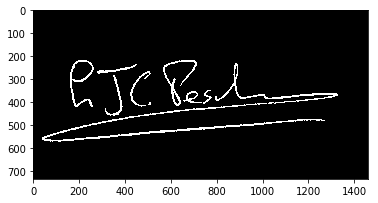

In [28]:
sample = preprocess_image(genuine_image_paths + "\\" + genuine_image_features[0][0]['name'])
plt.imshow(sample , cmap= 'gray')
plt.show()

In [29]:
def get_contour_features(im, display=False):
    '''
    :param im: input preprocessed image
    :param display: flag - if true display images
    :return:aspect ratio of bounding rectangle, area of : bounding rectangle, contours and convex hull
    '''

    rect = cv2.minAreaRect(cv2.findNonZero(im))
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    w = np.linalg.norm(box[0] - box[1])
    h = np.linalg.norm(box[1] - box[2])

    aspect_ratio = max(w, h) / min(w, h)
    bounding_rect_area = w * h

    if display:
        image1 = cv2.drawContours(im.copy(), [box], 0, (120, 120, 120), 2)
        cv2.imshow("a", cv2.resize(image1, (0, 0), fx=2.5, fy=2.5))
        cv2.waitKey()

    hull = cv2.convexHull(cv2.findNonZero(im))

    if display:
        convex_hull_image = cv2.drawContours(im.copy(), [hull], 0, (120, 120, 120), 2)
        cv2.imshow("a", cv2.resize(convex_hull_image, (0, 0), fx=2.5, fy=2.5))
        cv2.waitKey()

    im2, contours, hierarchy = cv2.findContours(im.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    if display:
        contour_image = cv2.drawContours(im.copy(), contours, -1, (120, 120, 120), 3)
        cv2.imshow("a", cv2.resize(contour_image, (0, 0), fx=2.5, fy=2.5))   
        cv2.waitKey()

    contour_area = 0
    for cnt in contours:
        contour_area += cv2.contourArea(cnt)
    hull_area = cv2.contourArea(hull)

    return aspect_ratio, bounding_rect_area, hull_area, contour_area

des_list = []

def sift(im, path, display=False):
    raw_image = cv2.imread(path)
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(im, None)

    if display:
        cv2.drawKeypoints(im, kp, raw_image)
        cv2.imshow('sift_keypoints.jpg', cv2.resize(raw_image, (0, 0), fx=3, fy=3))
        cv2.waitKey()

    return (path, des)


In [30]:
rect = cv2.minAreaRect(cv2.findNonZero(sample))
rect

((674.2774047851562, 353.61431884765625),
 (1301.430908203125, 348.3066101074219),
 -4.51807165145874)

In [35]:
box = cv2.boxPoints(rect)
box

array([[  39.302734,  578.4856  ],
       [  11.865356,  231.26135 ],
       [1309.2521  ,  128.74304 ],
       [1336.6895  ,  475.9673  ]], dtype=float32)

In [36]:
np.int0(box)

array([[  39,  578],
       [  11,  231],
       [1309,  128],
       [1336,  475]], dtype=int64)

In [38]:
[np.int0(box)]

[array([[  39,  578],
        [  11,  231],
        [1309,  128],
        [1336,  475]], dtype=int64)]

In [41]:
(((box[0] - box[1])**2).sum())**0.5

348.3065953653476

In [42]:
np.linalg.norm(box[0]- box[1])

348.3066

In [43]:
np.linalg.norm(box[1]- box[2])

1301.4309

In [46]:
hash = imagehash.phash(Image.open(genuine_image_paths + "\\" + genuine_image_features[0][0]['name']))

In [59]:
int(str(hash),16)

13822040011187764707

In [89]:
cor = 0
wrong = 0

im_contour_features = []
acc = []

for k in [5,10,20,50,100,150,200]:
    for i in range(30):
        des_list = []
        for im in genuine_image_features[i]:
            image_path = genuine_image_paths + "/" + im['name']
            preprocessed_image = preprocess_image(image_path)
            hash = imagehash.phash(Image.open(image_path))

            aspect_ratio, bounding_rect_area, convex_hull_area, contours_area = \
                get_contour_features(preprocessed_image.copy(), display=False)

            hash = int(str(hash), 16)
            im['hash'] = hash
            im['aspect_ratio'] = aspect_ratio
            im['hull_area/bounding_area'] = convex_hull_area / bounding_rect_area
            im['contour_area/bounding_area'] = contours_area / bounding_rect_area

            im_contour_features.append([hash, aspect_ratio, convex_hull_area / bounding_rect_area, contours_area / bounding_rect_area])

            des_list.append(sift(preprocessed_image, image_path))


        for im in forged_image_features[i]:
            image_path = forged_image_paths + "/" + im['name']
            preprocessed_image = preprocess_image(image_path)
            hash = imagehash.phash(Image.open(image_path))

            aspect_ratio, bounding_rect_area, convex_hull_area, contours_area = \
                get_contour_features(preprocessed_image.copy(), display=False)

            hash = int(str(hash), 16)
            im['hash'] = hash
            im['aspect_ratio'] = aspect_ratio
            im['hull_area/bounding_area'] = convex_hull_area / bounding_rect_area
            im['contour_area/bounding_area'] = contours_area / bounding_rect_area

            im_contour_features.append([hash, aspect_ratio, convex_hull_area / bounding_rect_area, contours_area / bounding_rect_area])

            des_list.append(sift(preprocessed_image, image_path))

        descriptors = des_list[0][1]
        for image_path, descriptor in des_list[1:]:
            descriptors = np.vstack((descriptors, descriptor))
        voc, variance = kmeans(descriptors, k,1)

        # Calculate the histogram of features
        im_features = np.zeros((len(genuine_image_features[i]) + len(forged_image_features[i]), k+4), "float32")
        for i in range(len(genuine_image_features[i]) + len(forged_image_features[i])):
            words, distance = vq(des_list[i][1], voc)
            for w in words:
                im_features[i][w] += 1

            for j in range(4):
                im_features[i][k+j] = im_contour_features[i][j]

        #nbr_occurences = np.sum((im_features > 0) * 1, axis=0)
        #idf = np.array(np.log((1.0 * len(image_paths) + 1) / (1.0 * nbr_occurences + 1)), 'float32')

        # Scaling the words
        stdSlr = StandardScaler().fit(im_features)
        im_features = stdSlr.transform(im_features)

        train_genuine_features, test_genuine_features = im_features[0:3], im_features[3:5]

        train_forged_features, test_forged_features = im_features[5:8], im_features[8:10]

        #clf = linear_model.LogisticRegression(C=1e5)

        clf = LinearSVC()
        #clf = tree.DecisionTreeClassifier()
        #clf = tree.DecisionTreeRegressor()
        #clf = svm.SVC()
        clf.fit(np.concatenate((train_forged_features,train_genuine_features)), np.array([1 for x in range(len(train_forged_features))] + [2 for x in range(len(train_genuine_features))]))



        #print("2" + str(clf.predict(test_genuine_features)))
        genuine_res = clf.predict(test_genuine_features)

        for res in genuine_res:
            if int(res) == 2:
                cor += 1
            else:
                wrong += 1

        #print("1" + str(clf.predict(test_forged_features)))
        forged_res = clf.predict(test_forged_features)

        for res in forged_res:
            if int(res) == 1:
                cor += 1
            else:
                wrong += 1

    acc.append(float(cor)/(cor+wrong))        

In [79]:
kmeans?

In [64]:
a,b = sift(sample,genuine_image_paths + "\\" + genuine_image_features[0][0]['name'])

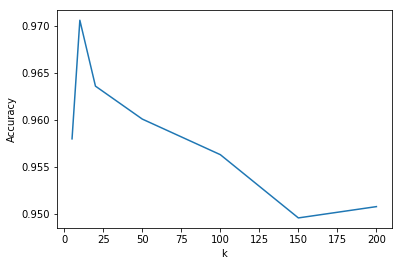

In [91]:
import matplotlib.pyplot as plt
plt.plot([5,10,20,50,100,150,200],acc)
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.show()

In [76]:
vq?